<a href="https://colab.research.google.com/github/Blackcipher101/DeepLearning/blob/master/transferlearnigflowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import tensorflow as tf

In [29]:
import matplotlib.pylab as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers
import numpy as np
import PIL.Image as Image

In [30]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [31]:
CLASSIFIER_URL ="https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

In [32]:
(train_examples, validation_examples), info = tfds.load(
    'tf_flowers', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:70%]', 'train[70%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [33]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [36]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

In [37]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

IndexError: ignored

In [38]:
URL = "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 2048)


In [39]:
feature_extractor.trainable = False

In [40]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(5)
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_5 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [42]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 8
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/8
81/81 [==============================] - 9s 109ms/step - loss: 0.2129 - accuracy: 0.9350 - val_loss: 0.3856 - val_accuracy: 0.8556
Epoch 2/8
81/81 [==============================] - 8s 103ms/step - loss: 0.1797 - accuracy: 0.9467 - val_loss: 0.3924 - val_accuracy: 0.8692
Epoch 3/8
81/81 [==============================] - 9s 106ms/step - loss: 0.1561 - accuracy: 0.9510 - val_loss: 0.3516 - val_accuracy: 0.8719
Epoch 4/8
81/81 [==============================] - 9s 107ms/step - loss: 0.1447 - accuracy: 0.9583 - val_loss: 0.3567 - val_accuracy: 0.8701
Epoch 5/8
81/81 [==============================] - 8s 105ms/step - loss: 0.1238 - accuracy: 0.9673 - val_loss: 0.3573 - val_accuracy: 0.8674
Epoch 6/8
81/81 [==============================] - 9s 106ms/step - loss: 0.1162 - accuracy: 0.9692 - val_loss: 0.3567 - val_accuracy: 0.8728
Epoch 7/8
81/81 [==============================] - 8s 103ms/step - loss: 0.1122 - accuracy: 0.9700 - val_loss: 0.3730 - val_accuracy: 0.8665
Epoch 8/8
81/

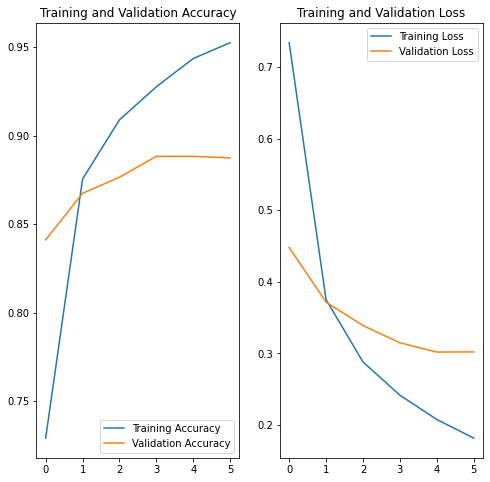

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()